In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [93]:
ticker='SOKM.IS'
start="2022-06-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
sokm=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [94]:
sokm.index=pd.to_datetime(sokm.index)
sokm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-01,13.500000,14.090000,13.450000,14.000000,14.000000,15654256
2022-06-02,14.100000,14.790000,13.970000,14.790000,14.790000,15430153
2022-06-03,14.730000,14.880000,14.550000,14.610000,14.610000,5617383
2022-06-06,14.730000,14.940000,14.570000,14.650000,14.650000,5794008
2022-06-07,14.670000,14.810000,14.350000,14.750000,14.750000,6562194
...,...,...,...,...,...,...
2023-06-15,30.740000,31.900000,30.740000,31.900000,31.900000,4568659
2023-06-16,32.000000,32.820000,31.700001,32.299999,32.299999,7274382
2023-06-19,32.340000,32.639999,31.400000,31.719999,31.719999,6626685


In [95]:
close=pd.DataFrame(sokm["Close"])

close


,Close
Date,
2022-06-01,14.000000
2022-06-02,14.790000
2022-06-03,14.610000
2022-06-06,14.650000
2022-06-07,14.750000
...,...
2023-06-15,31.900000
2023-06-16,32.299999
2023-06-19,31.719999


In [96]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=14).mean()
rolling_app21=close.rolling(window=21).mean()



In [97]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [98]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2022-06-29,11.690000,12.266,12.738571,13.320476
2022-06-30,11.460000,12.018,12.560000,13.199524
2022-07-01,11.890000,11.864,12.473571,13.061428
2022-07-04,11.970000,11.794,12.385000,12.935714
2022-07-05,11.770000,11.756,12.298571,12.798571
...,...,...,...,...
2023-06-15,31.900000,31.312,29.391429,29.240000
2023-06-16,32.299999,31.588,29.790000,29.349524
2023-06-19,31.719999,31.532,30.125714,29.431428


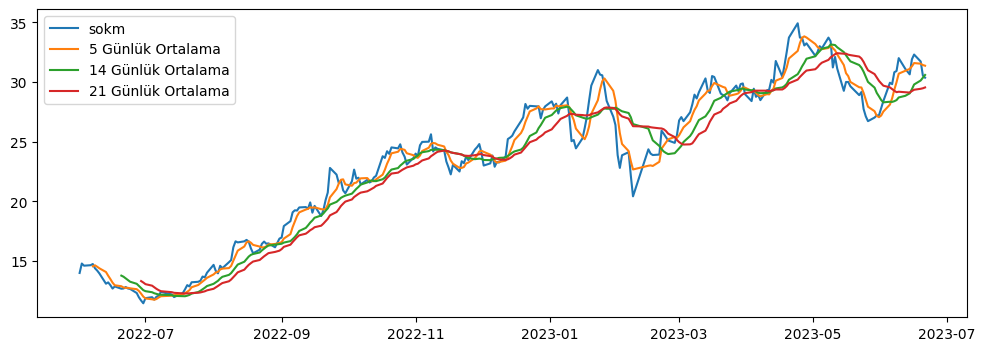

In [99]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='sokm')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='14 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='21 Günlük Ortalama')
ax.legend(loc='upper left')


In [100]:
def buy_sell_MA(data,opt=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    up=data[(np.array(data["short"]-data["mid"])>0) & (np.array(data["short"]-data["long"])>0)]
    down=data[(np.array(data["short"]-data["mid"])<0) & (np.array(data["short"]-data["long"])<0)]
    ups=np.percentile(np.array(up["short"]-up["mid"]),opt)
    downs=np.percentile(np.array(down["short"]-down["long"]),opt)


    for i in range(0,len(data)):
       if (data["short"][i]>data["mid"][i]+ups) & (data["short"][i]>data["long"][i]+ups):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
       elif(data["short"][i]<data["mid"][i]+downs)&(data["short"][i]<data["long"][i]+downs):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
       else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    
    PL=np.sum(operations)
    

    
    
    return (buy_signal,sell_signal,PL)





In [101]:
MAs["Buy"]=buy_sell_MA(MAs)[0]
MAs["Sell"]=buy_sell_MA(MAs)[1]

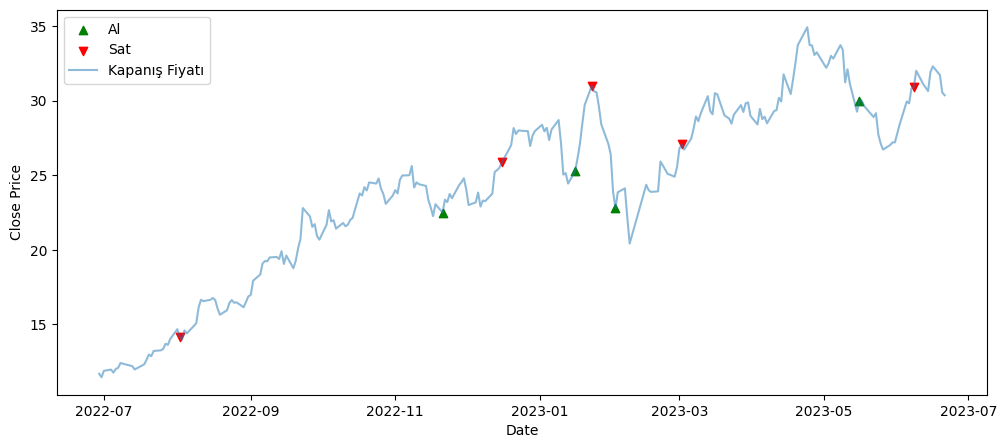

In [102]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

## Optimizing percentile variable to find best performance

In [103]:
def kar(percentile):
    MAs["Buy"]=buy_sell_MA(MAs,percentile)[0]
    MAs["Sell"]=buy_sell_MA(MAs,percentile)[1]
    al=MAs["Buy"]
    al=al.dropna(axis=0)
    sat=MAs["Sell"]
    sat=sat.dropna(axis=0)
    sat_val=sat.values
    al_val=al.values
    res=[]
    if len(al_val)==len(sat_val):
        for i in range(len(al_val)):
           res.append(sat_val[i]/al_val[i])
    elif len(al_val)>len(sat_val):
        al_val=np.delete(al_val,-1)
        for j in range(len(sat_val)):
           res.append(sat_val[j]/al_val[j])
    elif (len(sat_val)>len(al_val)):
        sat_val=np.delete(sat_val,0)
        for k in range(len(al_val)):
            res.append(sat_val[k]/al_val[k])
    
        

    
       

    

    df=pd.DataFrame()
    df["Kar"]=res

    return np.prod(df["Kar"])

In [104]:
MAs["Buy"]=buy_sell_MA(MAs,50)[0]
MAs["Sell"]=buy_sell_MA(MAs,50)[1]
al=MAs["Buy"]
al=al.dropna(axis=0)
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat_val=sat.values
al_val=al.values

In [105]:
percentile=range(1,100)



In [106]:
kardf=pd.DataFrame()
kardf["Percentile"]=percentile

In [107]:

for i in range(len(percentile)):
  kardf.loc[i,1]=kar(percentile[i])

In [108]:
kardf.columns=["Percentile","Performance"]
kardf=kardf.sort_values(by="Performance",ascending=False)
kardf

,Percentile,Performance
88,89,4.770492
87,88,4.770492
89,90,4.702730
86,87,4.684897
91,92,4.420256
...,...,...
23,24,1.110282
22,23,1.110282
21,22,1.110282
20,21,1.110282


In [109]:
MAs["Buy"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[0]
MAs["Sell"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[1]

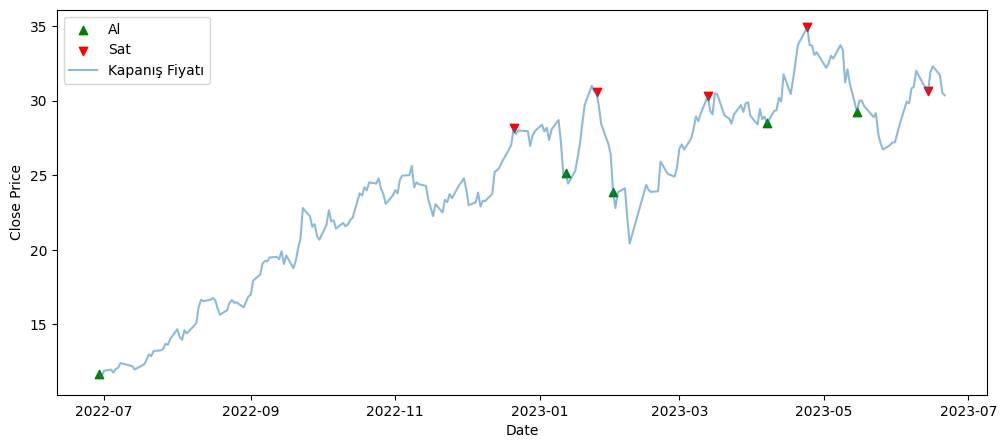

In [110]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [111]:
al=MAs["Buy"]
al=al.dropna(axis=0)
al

Date
2022-06-29    11.690000
2023-01-12    25.139999
2023-02-01    23.879999
2023-04-07    28.480000
2023-05-15    29.260000
Name: Buy, dtype: float64

In [112]:
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat


Date
2022-12-21    28.160000
2023-01-25    30.559999
2023-03-13    30.299999
2023-04-24    34.919998
2023-06-14    30.639999
Name: Sell, dtype: float64

In [113]:
sat_val=sat.values
al_val=al.values


In [114]:
res=[]

for i in range(len(al_val)):
    res.append((sat_val[i]/al_val[i]))

In [115]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,2.408897
1,1.215593
2,1.268844
3,1.226124
4,1.047163


In [116]:
res0=[100]
for i in range(len(df.index)):
    res0.append(res0[i]*df["Kar"].loc[i])

df["Eldeki Para"]=res0[1:]
df


,Kar,Eldeki Para
0,2.408897,240.889657
1,1.215593,292.823705
2,1.268844,371.547670
3,1.226124,455.563349
4,1.047163,477.049235


In [117]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 377.04923508419387
